# Building a Predictive Model for Bike Share
### 2022-04-02 WORK IN PROGRESS

Brian Nei and David Hu <br>
The University of British Columbia <br>
CIVL 498A - Machine Learning in Construction Management <br>

Background:
Docked bike share is an effective tool to encourage active transportation in highly dense areas. It avoids the issues seen with dockless systems (such as those seen in China), where enormous numbers of bikes end up in the same areas. However, docked bike share providers often need to move bikes between docks to accomodate usage patterns. <br>

Our goal was to develop a method to allow bike share providers to predict the anticipated demand of bikes in each locale (this is flexible). In this case, we chose to analyze New York City's Citi Bike system, as it had readily available data online, and grouped demand by zip code (approximately 60). However, we expect that this method can be broadly applied to other systems worldwide. <br>

This method relies on just three factors that should be readily available to any bike share provider: Number of subscribers, date information (weekend, holiday), and the weather forecast. <br>
### POTENTIAL APPLICATIONS

This method allows bike share providers to see predicted usage patterns based on easily-available factors. For example, some areas of a city may only see high bike share usage on sunny weekend days. Others may be agnostic to weather, but have reduced usage on weekends and holidays. <br>

Is this code efficient? No. 
Should you run this on a computer with less than 16GB of RAM? Also no.

We start by importing in our required Python packages.

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib as plt
import geopandas

Next, we bring in all available Citi Bike data from 2018 and 2019. If you're running this locally, you should have a computer that is able to store all data in RAM. In this case, 2 years of NYC data is approximately 10GB.

In [2]:
#Using Citi Bike data from 2019 (pre-covid)
#These files are gigantic
#Run this and go grab a coffee

jan = pd.read_csv("./citibikedata/201901-citibike-tripdata.csv")
feb = pd.read_csv("./citibikedata/201902-citibike-tripdata.csv")
mar = pd.read_csv("./citibikedata/201903-citibike-tripdata.csv")
apr = pd.read_csv("./citibikedata/201904-citibike-tripdata.csv")
may = pd.read_csv("./citibikedata/201905-citibike-tripdata.csv")
jun = pd.read_csv("./citibikedata/201906-citibike-tripdata.csv")
jul = pd.read_csv("./citibikedata/201907-citibike-tripdata.csv")
aug = pd.read_csv("./citibikedata/201908-citibike-tripdata.csv")
sep = pd.read_csv("./citibikedata/201909-citibike-tripdata.csv")
octb = pd.read_csv("./citibikedata/201910-citibike-tripdata.csv")
nov = pd.read_csv("./citibikedata/201911-citibike-tripdata.csv")
dec = pd.read_csv("./citibikedata/201912-citibike-tripdata.csv")
jan18 = pd.read_csv("./citibikedata/201801-citibike-tripdata.csv")
feb18 = pd.read_csv("./citibikedata/201802-citibike-tripdata.csv")
mar18 = pd.read_csv("./citibikedata/201803-citibike-tripdata.csv")
apr18 = pd.read_csv("./citibikedata/201804-citibike-tripdata.csv")
may18 = pd.read_csv("./citibikedata/201805-citibike-tripdata.csv")
jun18 = pd.read_csv("./citibikedata/201806-citibike-tripdata.csv")
jul18 = pd.read_csv("./citibikedata/201807-citibike-tripdata.csv")
aug18 = pd.read_csv("./citibikedata/201808-citibike-tripdata.csv")
sep18 = pd.read_csv("./citibikedata/201809-citibike-tripdata.csv")
octb18 = pd.read_csv("./citibikedata/201810-citibike-tripdata.csv")
nov18 = pd.read_csv("./citibikedata/201811-citibike-tripdata.csv")
dec18 = pd.read_csv("./citibikedata/201812-citibike-tripdata.csv")

#Combining 12 months of data into one dataframe
months = [jan18, feb18, mar18, apr18, may18, jun18, jul18, aug18, sep18, octb18, nov18, dec18, jan, feb, mar, apr, may, jun, jul, aug, sep, octb, nov, dec]

cb = pd.concat(months)
cb.reset_index(inplace=True, drop=True)
cb["starttime"] = pd.to_datetime(cb["starttime"])
cb["stoptime"] = pd.to_datetime(cb["stoptime"])
cb = cb.dropna()

Using GeoPandas, we take the longitude and latitude of each trip's start and end point. In this case, it is embedded into the dataset already, and we just need to convert it to a GeoPandas coordinate point. We then set its Coordinate Reference system (CRS) to long/lat. 

In [3]:
#Using geopandas to convert all start stations to points, adds a "geometry" column to the end of the dataframe
gdf = geopandas.GeoDataFrame(cb, geometry = geopandas.points_from_xy(cb["start station longitude"], cb["start station latitude"]))

In [4]:
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:4326")
gdf


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,geometry
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,W 52 St & 11 Ave,40.767272,-73.993929,505.0,6 Ave & W 33 St,40.749013,-73.988484,31956,Subscriber,1992,1,POINT (-73.99393 40.76727)
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,W 52 St & 11 Ave,40.767272,-73.993929,3255.0,8 Ave & W 31 St,40.750585,-73.994685,32536,Subscriber,1969,1,POINT (-73.99393 40.76727)
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,W 52 St & 11 Ave,40.767272,-73.993929,525.0,W 34 St & 11 Ave,40.755942,-74.002116,16069,Subscriber,1956,1,POINT (-73.99393 40.76727)
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,W 52 St & 11 Ave,40.767272,-73.993929,447.0,8 Ave & W 52 St,40.763707,-73.985162,31781,Subscriber,1974,1,POINT (-73.99393 40.76727)
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,W 52 St & 11 Ave,40.767272,-73.993929,3356.0,Amsterdam Ave & W 66 St,40.774667,-73.984706,30319,Subscriber,1992,1,POINT (-73.99393 40.76727)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38100031,93,2019-12-31 23:58:18.016,2019-12-31 23:59:51.636,3141.0,1 Ave & E 68 St,40.765005,-73.958185,3142.0,1 Ave & E 62 St,40.761227,-73.960940,28734,Subscriber,1985,2,POINT (-73.95818 40.76501)
38100032,786,2019-12-31 23:58:59.896,2020-01-01 00:12:06.346,490.0,8 Ave & W 33 St,40.751551,-73.993934,513.0,W 56 St & 10 Ave,40.768254,-73.988639,41418,Subscriber,1991,1,POINT (-73.99393 40.75155)
38100033,351,2019-12-31 23:59:03.695,2020-01-01 00:04:54.873,3349.0,Grand Army Plaza & Plaza St West,40.672968,-73.970880,3368.0,5 Ave & 3 St,40.672815,-73.983524,27746,Subscriber,1935,2,POINT (-73.97088 40.67297)
38100034,1571,2019-12-31 23:59:21.361,2020-01-01 00:25:32.942,252.0,MacDougal St & Washington Sq,40.732264,-73.998522,366.0,Clinton Ave & Myrtle Ave,40.693261,-73.968896,28506,Subscriber,1980,1,POINT (-73.99852 40.73226)


A zipcode map is conveniently available from NYC OpenData. However, we need to convert it from the Mercator Projection to our long/lat system. Fortunately, GeoPandas makes this trivial.

<AxesSubplot:>

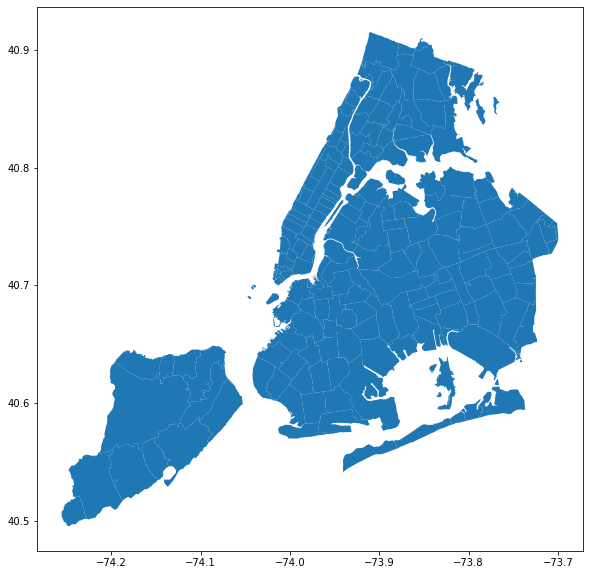

In [5]:
#Loads in a zipcode map from NYC open data, and converts from Mercator to Long/Lat (to match the Citi Bike data)
#We could have also converted all Citi Bike data into Mercator, but it has 7 million rows
zipcodes = geopandas.GeoDataFrame.from_file("./zipcodes")
zipcodes = zipcodes.to_crs("EPSG:4326")

#Plots map (it's pretty!)
zipcodes.plot(figsize = (20,10))


We then only take the first instance of each station, and drop everything else. In this way, we generate a list of unique station IDs, and only keep what is relevant to us (coordinates). Then we plot our stations on a map of the city to ensure that we've done everything correctly. 

In [6]:
#Creates a dataframe of each individual station and its coordinates in lon/lat
stationsList = gdf.drop_duplicates("start station id")
stationsList = stationsList[["start station id", "start station latitude", "start station longitude", "start station name", "geometry"]]
stationsList.reset_index(inplace = True, drop = True)

<AxesSubplot:>

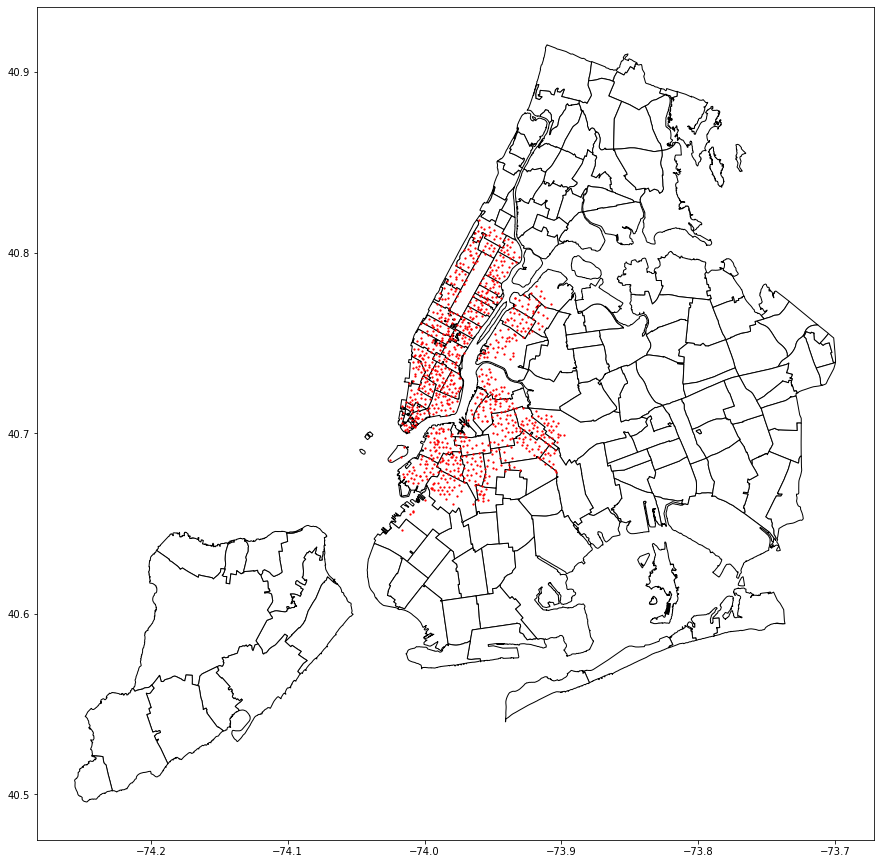

In [7]:
#Plots all of our stations onto a map of NYC
stationsPlot = stationsList
stationsPlot = stationsPlot.drop(index=607)
stationsPlot = stationsPlot.drop(index=752)

ax = zipcodes.plot(color = 'white', edgecolor = 'black', figsize = (15, 30))
stationsPlot.plot(ax = ax, color = 'red', markersize = 1.5)


Now, we locate each station with GeoPandas. This is by cycling through each zipcode on the map, until we find one that our station is in. This is repeated for every station. 
Readers should note that this is a terribly inefficient way of doing this. I am open to suggestions on how to improve this part.

In [8]:
#Now we determine the zip code of each station (this is computationally quite intensive)
stationZip = [0] * len(stationsList)
for i in range(len(stationsList)):
    foundZip = False
    while foundZip == False:
        #There are a few problem stations that we will just hardcode to 0 and drop later
        if(i == 87):
            stationZip[87] = 10043
            foundZip = True
        if(i == 607):
            stationZip[607] = 0
            foundZip = True
        if(i == 752):
            stationZip[752] = 0
            foundZip = True
        for j in range(len(zipcodes)):
            if (stationsList.loc[i]['geometry'].within(zipcodes.loc[j]['geometry'])):
                #print("We are on Station", i, "Station ID", stationsList.loc[i]['start station id'], "is in", zipcodes.loc[j]['ZIPCODE'])
                stationZip[i] = zipcodes.loc[j]['ZIPCODE']
                foundZip = True


Now, we create a DataFrame with the start and end zip code of every single trip in our dataset (around 20 million). This takes a little while. Then, we print out how many unique zip codes are in our dataset.

In [9]:
#Now we add those zipcodes to our dataframe
stationsList['zipcode'] = stationZip
stationsList = stationsList.rename(columns={'start station id': 'station id', 'start station latitude': 'station latitude', 'start station longitude': 'station longitude', 'start station name': 'station name'})

#Creates a two dfs of just stations numbers and their associated zip codes
startStationZips = stationsList.drop(columns = ['station latitude', 'station longitude', 'station name', 'geometry'])
startStationZips = startStationZips.rename(columns={'station id': 'start station id', 'zipcode': 'startzipcode'})
endStationZips = stationsList.drop(columns = ['station latitude', 'station longitude', 'station name', 'geometry'])
endStationZips = endStationZips.rename(columns={'station id': 'end station id', 'zipcode': 'endzipcode'})

#Now we tack on zip codes to each indidual trip taken in the entire dataset
mergedGDF = pd.merge(gdf, startStationZips, how = 'left')
mergedGDF = pd.merge(mergedGDF, endStationZips, how = 'left')

#How many zip codes have stations?
numZips = len(stationsList.zipcode.unique())
print("There are", numZips, "unique zip codes that contain at least one Citi Bike station in 2018 and 2019")

#This is a pretty good number, granular enough to draw conclusions about demand while not being overwhelmingly large


There are 65 unique zip codes that contain at least one Citi Bike station in 2018 and 2019


Our resulting dataframe:

In [10]:
mergedGDF.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,geometry,startzipcode,endzipcode
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,W 52 St & 11 Ave,40.767272,-73.993929,505.0,6 Ave & W 33 St,40.749013,-73.988484,31956,Subscriber,1992,1,POINT (-73.99393 40.76727),10019,10001
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,W 52 St & 11 Ave,40.767272,-73.993929,3255.0,8 Ave & W 31 St,40.750585,-73.994685,32536,Subscriber,1969,1,POINT (-73.99393 40.76727),10019,10001
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,W 52 St & 11 Ave,40.767272,-73.993929,525.0,W 34 St & 11 Ave,40.755942,-74.002116,16069,Subscriber,1956,1,POINT (-73.99393 40.76727),10019,10001
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,W 52 St & 11 Ave,40.767272,-73.993929,447.0,8 Ave & W 52 St,40.763707,-73.985162,31781,Subscriber,1974,1,POINT (-73.99393 40.76727),10019,10019
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,W 52 St & 11 Ave,40.767272,-73.993929,3356.0,Amsterdam Ave & W 66 St,40.774667,-73.984706,30319,Subscriber,1992,1,POINT (-73.99393 40.76727),10019,10023


Let's reduce this down to what we actually need for our regression.

In [11]:
#Now we just take the data we need - the date of each trip and its start and end zipcode
#Ignore the warning
tripDF = mergedGDF[['starttime', 'startzipcode', 'endzipcode']]
tripDF['starttime'] = pd.to_datetime(tripDF['starttime']).dt.date
tripDF = tripDF.rename(columns={'starttime': 'date'})

C:\Users\brian\AppData\Local\Temp/ipykernel_10260/1110067669.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tripDF['starttime'] = pd.to_datetime(tripDF['starttime']).dt.date


Now let's split this into two DataFrames: One for trips originating from each zip code, and one for trips that end in each. Apologies if you actually try to read this code.

In [12]:
#Create a separate dataframes for start and end zipcodes
startDF = tripDF.drop(columns="endzipcode")
endDF = tripDF.drop(columns="startzipcode")

startFreqs = startDF.value_counts(sort=False)
endFreqs = endDF.value_counts(sort=False)

#Convert the above to dataframes
startFreqs = startFreqs.to_frame()
endFreqs = endFreqs.to_frame()

#Create a table of trips originating and ending from each zip code per date, fill in any NaNs with the next day's number
#This is just a horrible block of code, I'm sorry if you ever want to reuse it :(
startFreqs = startFreqs.reset_index().pivot('date', 'startzipcode')
startFreqs.fillna(method='backfill', inplace=True)
startFreqs.columns = startFreqs.columns.droplevel(0)
startFreqs = startFreqs.reset_index()
startFreqs.columns.name = None
startFreqs['date'] = pd.to_datetime(startFreqs['date'])
startFreqs = startFreqs.drop(startFreqs.columns[1], axis=1)

endFreqs = endFreqs.reset_index().pivot('date', 'endzipcode')
endFreqs.fillna(method='backfill', inplace=True)
endFreqs.columns = endFreqs.columns.droplevel(0)
endFreqs = endFreqs.reset_index()
endFreqs.columns.name = None
endFreqs['date'] = pd.to_datetime(endFreqs['date'])
endFreqs = endFreqs.drop(endFreqs.columns[1], axis=1)

In case you're confused by the above code, this is what we end up with for our "originating zipcode" DataFrame.

In [13]:
startFreqs.head()

,date,10043,00083,10001,10002,10003,10004,10005,10007,10009,...,11222,11225,11231,11232,11233,11237,11238,11249,11251,11385
0,2018-01-01,4.0,155.0,244.0,372.0,440.0,20.0,28.0,52.0,287.0,...,90.0,7.0,67.0,1.0,4.0,11.0,120.0,77.0,6.0,2.0
1,2018-01-02,38.0,357.0,1204.0,791.0,1308.0,102.0,200.0,350.0,588.0,...,236.0,14.0,202.0,7.0,5.0,11.0,209.0,214.0,22.0,2.0
2,2018-01-03,51.0,370.0,1636.0,942.0,1715.0,141.0,236.0,401.0,906.0,...,335.0,28.0,267.0,14.0,8.0,11.0,305.0,257.0,33.0,2.0
3,2018-01-04,5.0,35.0,125.0,81.0,112.0,10.0,12.0,34.0,102.0,...,35.0,3.0,27.0,8.0,1.0,11.0,21.0,24.0,3.0,2.0
4,2018-01-05,8.0,75.0,285.0,266.0,341.0,34.0,43.0,74.0,256.0,...,88.0,2.0,55.0,8.0,1.0,11.0,57.0,70.0,13.0,2.0


This just creates a list of dates in each year.

In [14]:
daterange = pd.date_range('2018-01-01', periods=730, freq='D')
daterange2018 = pd.date_range('2018-01-01', periods=365, freq='D')
daterange2019 = pd.date_range('2019-01-01', periods=365, freq='D')

Let's bring in our first feature dataset - weather recorded from Central Park. We have 5 features here: Liquid Precipitation (inches), Snowfall (inches), Snow Depth (inches), Max Temp (F), and Min Temp (F)

In [15]:
weather = pd.read_csv("noaafull2018.csv")
weather["date"] = pd.to_datetime(weather["date"])
weather.head()


,date,prec,snow,snow_depth,temp_max,temp_min
0,2018-01-01,0.00,0.0,0.0,19,7
1,2018-01-02,0.00,0.0,0.0,26,13
2,2018-01-03,0.00,0.0,0.0,30,16
3,2018-01-04,0.76,9.8,1.2,29,19
4,2018-01-05,0.00,0.0,7.1,19,9


Our next feature set - two boolean variables. These are: is_weekend, and is_holiday. Holidays are hardcoded in. Please reach out if you know of a better way :(

In [16]:
import datetime as dt
pd.options.mode.chained_assignment = None #Supresses the warning for the bad thing we're about to do

dateInfoDF = pd.DataFrame({'date': daterange})
dateInfoDF["is_weekend"] = dateInfoDF['date'].dt.dayofweek > 4
dateInfoDF["is_holiday"] = False

#Hardcoding public holidays by hand

dateInfoDF.loc[dateInfoDF['date'] == '2018-01-01', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-01-15', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-02-12', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-02-19', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-05-28', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-07-04', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-09-03', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-10-08', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-11-12', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-11-22', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-12-24', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-12-25', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-12-31', 'is_holiday'] = True #NYE isn't a true holiday, but probably has similar usage patterns to one
dateInfoDF.loc[dateInfoDF['date'] == '2019-01-01', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-01-21', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-02-12', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-02-18', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-05-27', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-07-04', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-09-02', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-10-14', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-11-11', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-11-28', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-12-24', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-12-25', 'is_holiday'] = True
dateInfoDF.loc[dateInfoDF['date'] == '2018-12-31', 'is_holiday'] = True #NYE isn't a true holiday, but probably has similar usage patterns to one

dateInfoDF


,date,is_weekend,is_holiday
0,2018-01-01,False,True
1,2018-01-02,False,False
2,2018-01-03,False,False
3,2018-01-04,False,False
4,2018-01-05,False,False
...,...,...,...
725,2019-12-27,False,False
726,2019-12-28,True,False
727,2019-12-29,True,False
728,2019-12-30,False,False


Our last feature set - the number of active annual members in each month. Once again, there's probably a better way to do this if you're working with more data (the NYC data is in monthly PDF publications)

In [17]:
subInfoDF = pd.DataFrame({'date': daterange})
subInfoDF["subscribers"] = 0
subInfoDF.loc[(subInfoDF['date'] >= '2018-01-01') & (subInfoDF['date'] <= '2018-01-31'), 'subscribers'] = 137003
subInfoDF.loc[(subInfoDF['date'] >= '2018-02-01') & (subInfoDF['date'] <= '2018-02-28'), 'subscribers'] = 138109
subInfoDF.loc[(subInfoDF['date'] >= '2018-03-01') & (subInfoDF['date'] <= '2018-03-31'), 'subscribers'] = 138109
subInfoDF.loc[(subInfoDF['date'] >= '2018-04-01') & (subInfoDF['date'] <= '2018-04-30'), 'subscribers'] = 140462
subInfoDF.loc[(subInfoDF['date'] >= '2018-05-01') & (subInfoDF['date'] <= '2018-05-31'), 'subscribers'] = 144590
subInfoDF.loc[(subInfoDF['date'] >= '2018-06-01') & (subInfoDF['date'] <= '2018-06-30'), 'subscribers'] = 146533
subInfoDF.loc[(subInfoDF['date'] >= '2018-07-01') & (subInfoDF['date'] <= '2018-07-31'), 'subscribers'] = 147040
subInfoDF.loc[(subInfoDF['date'] >= '2018-08-01') & (subInfoDF['date'] <= '2018-08-31'), 'subscribers'] = 146567
subInfoDF.loc[(subInfoDF['date'] >= '2018-09-01') & (subInfoDF['date'] <= '2018-09-30'), 'subscribers'] = 146437
subInfoDF.loc[(subInfoDF['date'] >= '2018-10-01') & (subInfoDF['date'] <= '2018-10-31'), 'subscribers'] = 146760
subInfoDF.loc[(subInfoDF['date'] >= '2018-11-01') & (subInfoDF['date'] <= '2018-11-30'), 'subscribers'] = 146760
subInfoDF.loc[(subInfoDF['date'] >= '2018-12-01') & (subInfoDF['date'] <= '2018-12-31'), 'subscribers'] = 147090
subInfoDF.loc[(subInfoDF['date'] >= '2019-01-01') & (subInfoDF['date'] <= '2019-01-31'), 'subscribers'] = 151534
subInfoDF.loc[(subInfoDF['date'] >= '2019-02-01') & (subInfoDF['date'] <= '2019-02-28'), 'subscribers'] = 148447
subInfoDF.loc[(subInfoDF['date'] >= '2019-03-01') & (subInfoDF['date'] <= '2019-03-31'), 'subscribers'] = 150929
subInfoDF.loc[(subInfoDF['date'] >= '2019-04-01') & (subInfoDF['date'] <= '2019-04-30'), 'subscribers'] = 152482
subInfoDF.loc[(subInfoDF['date'] >= '2019-05-01') & (subInfoDF['date'] <= '2019-05-31'), 'subscribers'] = 152309
subInfoDF.loc[(subInfoDF['date'] >= '2019-06-01') & (subInfoDF['date'] <= '2019-06-30'), 'subscribers'] = 152314
subInfoDF.loc[(subInfoDF['date'] >= '2019-07-01') & (subInfoDF['date'] <= '2019-07-31'), 'subscribers'] = 153346
subInfoDF.loc[(subInfoDF['date'] >= '2019-08-01') & (subInfoDF['date'] <= '2019-08-31'), 'subscribers'] = 153726
subInfoDF.loc[(subInfoDF['date'] >= '2019-09-01') & (subInfoDF['date'] <= '2019-09-30'), 'subscribers'] = 153536
subInfoDF.loc[(subInfoDF['date'] >= '2019-10-01') & (subInfoDF['date'] <= '2019-10-31'), 'subscribers'] = 152465
subInfoDF.loc[(subInfoDF['date'] >= '2019-11-01') & (subInfoDF['date'] <= '2019-11-30'), 'subscribers'] = 152465
subInfoDF.loc[(subInfoDF['date'] >= '2019-12-01') & (subInfoDF['date'] <= '2019-12-31'), 'subscribers'] = 149740
subInfoDF


,date,subscribers
0,2018-01-01,137003
1,2018-01-02,137003
2,2018-01-03,137003
3,2018-01-04,137003
4,2018-01-05,137003
...,...,...
725,2019-12-27,149740
726,2019-12-28,149740
727,2019-12-29,149740
728,2019-12-30,149740


Building our feature DataFrame by combining our features. 

In [18]:
features = weather
features = pd.merge(features, dateInfoDF)
features = pd.merge(features, subInfoDF)

startFreqs = startFreqs.dropna(axis=1)
startFreqs = startFreqs.drop(columns=['11207', '11237', '11385'])
startFreqs = startFreqs.reset_index()

df_start = pd.merge(features, startFreqs)


Our final model:

In [19]:
features

,date,prec,snow,snow_depth,temp_max,temp_min,is_weekend,is_holiday,subscribers
0,2018-01-01,0.00,0.0,0.0,19,7,False,True,137003
1,2018-01-02,0.00,0.0,0.0,26,13,False,False,137003
2,2018-01-03,0.00,0.0,0.0,30,16,False,False,137003
3,2018-01-04,0.76,9.8,1.2,29,19,False,False,137003
4,2018-01-05,0.00,0.0,7.1,19,9,False,False,137003
...,...,...,...,...,...,...,...,...,...
725,2019-12-27,0.00,0.0,0.0,54,46,False,False,149740
726,2019-12-28,0.00,0.0,0.0,51,43,True,False,149740
727,2019-12-29,0.25,0.0,0.0,44,39,True,False,149740
728,2019-12-30,0.74,0.0,0.0,41,37,False,False,149740


In [20]:
df_start

,date,prec,snow,snow_depth,temp_max,temp_min,is_weekend,is_holiday,subscribers,index,...,11217,11221,11222,11225,11231,11232,11233,11238,11249,11251
0,2018-01-01,0.00,0.0,0.0,19,7,False,True,137003,0,...,119.0,15.0,90.0,7.0,67.0,1.0,4.0,120.0,77.0,6.0
1,2018-01-02,0.00,0.0,0.0,26,13,False,False,137003,1,...,324.0,38.0,236.0,14.0,202.0,7.0,5.0,209.0,214.0,22.0
2,2018-01-03,0.00,0.0,0.0,30,16,False,False,137003,2,...,392.0,43.0,335.0,28.0,267.0,14.0,8.0,305.0,257.0,33.0
3,2018-01-04,0.76,9.8,1.2,29,19,False,False,137003,3,...,34.0,5.0,35.0,3.0,27.0,8.0,1.0,21.0,24.0,3.0
4,2018-01-05,0.00,0.0,7.1,19,9,False,False,137003,4,...,79.0,12.0,88.0,2.0,55.0,8.0,1.0,57.0,70.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2019-12-27,0.00,0.0,0.0,54,46,False,False,149740,725,...,473.0,133.0,451.0,57.0,299.0,10.0,34.0,466.0,346.0,44.0
726,2019-12-28,0.00,0.0,0.0,51,43,True,False,149740,726,...,429.0,140.0,528.0,65.0,364.0,15.0,21.0,503.0,480.0,41.0
727,2019-12-29,0.25,0.0,0.0,44,39,True,False,149740,727,...,313.0,120.0,354.0,43.0,198.0,6.0,12.0,332.0,267.0,23.0
728,2019-12-30,0.74,0.0,0.0,41,37,False,False,149740,728,...,210.0,41.0,207.0,24.0,136.0,1.0,10.0,182.0,141.0,16.0


Super lazy way of getting indices for our training sample (2018) and test sample (2019). 2018 is a [0, 1... 364], 2019 is [365, 366... 729]. 

In [21]:
indices_2018 = [*range(0,365)]
indices_2019 = [*range(365, 730)]

Now we set up our training and testing DataFrames. 

In [22]:
from sklearn import linear_model, metrics, model_selection

X_train = features.drop(features.index[indices_2019])
X_train = X_train.drop('date', axis=1)

y_train = startFreqs.drop(startFreqs.index[indices_2019])
y_train = y_train.drop('date', axis=1)
y_train = y_train.drop('index', axis=1)

X_test = features.drop(features.index[indices_2018])
X_test = X_test.drop('date', axis=1)

y_test = startFreqs.drop(startFreqs.index[indices_2018])
y_test = y_test.reset_index()
y_test = y_test.drop('date', axis=1)
y_test = y_test.drop('index', axis=1)
y_test = y_test.drop('level_0', axis=1)


We're going to test out three linear models. Dialing these in will be done at a later date.

In [23]:
#Linear Models
linModel = linear_model.LinearRegression()
ridgeModel = linear_model.Ridge(alpha = 1)
lassoModel = linear_model.Lasso(alpha =  2)

In [24]:
linModel.fit(X_train, y_train)

LinearRegression()

In [25]:
from sklearn import model_selection

linModelResults = model_selection.cross_validate(linModel, X_train, y_train, scoring = ['neg_root_mean_squared_error'])
linRMSE = sum(linModelResults['test_neg_root_mean_squared_error'])/len(linModelResults['test_neg_root_mean_squared_error'])

ridgeModelResults = model_selection.cross_validate(ridgeModel, X_train, y_train, scoring = ['neg_root_mean_squared_error'])
ridgeRMSE = sum(ridgeModelResults['test_neg_root_mean_squared_error'])/len(ridgeModelResults['test_neg_root_mean_squared_error'])

lassoModelResults = model_selection.cross_validate(lassoModel, X_train, y_train, scoring = ['neg_root_mean_squared_error'])
lassoRMSE = sum(lassoModelResults['test_neg_root_mean_squared_error'])/len(lassoModelResults['test_neg_root_mean_squared_error'])


print("The linear regression's RMSE is", linRMSE)
print("The ridge regression's RMSE is", ridgeRMSE)
print("The lasso regression's RMSE is", lassoRMSE)


The linear regression's RMSE is -193.23175618412463
The ridge regression's RMSE is -193.22643282111983
The lasso regression's RMSE is -193.42277240093685


Support vector machines can be setup to give a multioutput similar to linear models. In this case, it doesn't work out too well. To be dialed in.

In [26]:
#Support Vector Multioutput
from sklearn import svm, multioutput

svr = svm.SVR(epsilon = 20, C = 10)
mor = multioutput.MultiOutputRegressor(svr)

svmResults = model_selection.cross_validate(mor, X_train, y_train, scoring = ['neg_root_mean_squared_error'])
svmRMSE = sum(svmResults['test_neg_root_mean_squared_error'])/len(svmResults['test_neg_root_mean_squared_error'])

print("The support vector regressor's RMSE is", svmRMSE)

The support vector regressor's RMSE is -405.5140198397209


Let's go with the LASSO regression for now. We fit it to the 2018 data.

In [27]:
lassoFinalModel = linear_model.Lasso()
lassoFinalModel.fit(X_train, y_train)

Lasso()

Let's use that LASSO regression to predict 2019 usage.

In [28]:
y_pred = lassoFinalModel.predict(X_test)
predictionDF = pd.DataFrame(y_pred)
predictionDF.columns = y_test.columns
predictionDF.insert(loc=0, column='date', value=daterange2019)
predictionDF

,date,10043,00083,10001,10002,10003,10004,10005,10007,10009,...,11217,11221,11222,11225,11231,11232,11233,11238,11249,11251
0,2019-01-01,142.676767,1583.869380,2571.136719,2018.912930,3260.172204,464.706814,445.072807,781.396133,1814.949514,...,838.162343,102.606627,787.722951,100.269986,654.068175,28.813965,31.444036,738.513168,730.079431,92.011255
1,2019-01-02,90.131504,841.395345,3005.309110,2005.078440,3553.965358,291.766822,447.872909,777.789539,1981.765153,...,824.960598,86.550223,727.974903,74.846429,574.783074,17.203905,22.692285,667.162897,593.630535,68.528313
2,2019-01-03,103.279658,990.642109,3108.244358,2100.325093,3688.912223,335.207718,472.469108,826.397014,2046.978390,...,862.861581,90.993905,773.866618,80.832359,612.677150,19.834224,24.735640,708.421996,643.703116,73.627283
3,2019-01-04,113.885786,1140.872547,3185.613546,2162.898589,3776.466864,367.929560,489.487856,860.209506,2072.695524,...,885.204562,92.401376,803.396908,85.334414,641.278215,21.806964,26.050658,743.223010,679.032169,78.631222
4,2019-01-05,64.493627,1102.005377,1461.845937,1889.968845,2606.851338,232.542286,201.660862,484.502750,1662.877429,...,740.443561,85.787288,699.172258,104.828678,549.052232,17.366841,25.318218,750.232565,675.221246,49.673173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,131.007555,1270.623681,3247.024291,2260.419763,3903.328445,427.617858,517.121071,920.265885,2156.551922,...,925.912460,99.550233,856.658433,88.823212,680.372619,25.855971,28.456382,765.927255,738.650142,81.884448
361,2019-12-28,96.665446,1517.055944,1842.792049,2203.643886,3089.654228,351.194404,277.474247,635.820164,1890.515127,...,859.421203,95.392347,824.697445,116.614522,661.023187,21.329588,26.830652,854.328623,812.445523,61.194494
362,2019-12-29,62.105253,1103.758368,1464.490661,1882.407430,2608.339796,229.572013,199.382754,483.689266,1651.883671,...,732.360537,82.383568,685.109689,99.761210,544.279190,15.783289,22.671061,730.640256,664.535886,47.657645
363,2019-12-30,54.302441,346.469475,2325.966099,1490.803401,2735.105569,151.497649,333.024640,563.000576,1569.305317,...,621.189097,69.059470,530.625039,50.493926,407.998560,14.515443,20.024285,480.563699,396.829157,52.000188


Now let's see the actual usage statistics in 2019. Keep in mind that the model has never seen 2019 data before.

In [29]:
y_plot = y_test
y_plot.insert(loc = 0, column = 'date', value = daterange2019)


In [30]:
y_plot 

,date,10043,00083,10001,10002,10003,10004,10005,10007,10009,...,11217,11221,11222,11225,11231,11232,11233,11238,11249,11251
0,2019-01-01,45.0,1201.0,812.0,1072.0,1242.0,126.0,155.0,361.0,1013.0,...,391.0,54.0,350.0,74.0,340.0,5.0,11.0,493.0,305.0,36.0
1,2019-01-02,60.0,1057.0,2273.0,1609.0,2539.0,296.0,376.0,639.0,1426.0,...,647.0,60.0,528.0,57.0,501.0,21.0,7.0,573.0,451.0,68.0
2,2019-01-03,89.0,975.0,2577.0,1763.0,2781.0,310.0,415.0,641.0,1661.0,...,716.0,73.0,625.0,57.0,516.0,21.0,14.0,619.0,523.0,59.0
3,2019-01-04,73.0,1091.0,2643.0,1942.0,2934.0,292.0,423.0,724.0,1853.0,...,718.0,73.0,652.0,66.0,574.0,18.0,21.0,703.0,568.0,59.0
4,2019-01-05,5.0,294.0,702.0,1025.0,1384.0,50.0,105.0,191.0,941.0,...,403.0,49.0,332.0,54.0,293.0,2.0,20.0,462.0,301.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,77.0,1024.0,1847.0,1632.0,2045.0,199.0,291.0,463.0,1494.0,...,473.0,133.0,451.0,57.0,299.0,10.0,34.0,466.0,346.0,44.0
361,2019-12-28,70.0,1301.0,1270.0,1598.0,1940.0,166.0,159.0,337.0,1361.0,...,429.0,140.0,528.0,65.0,364.0,15.0,21.0,503.0,480.0,41.0
362,2019-12-29,23.0,769.0,746.0,1053.0,1154.0,77.0,115.0,218.0,1036.0,...,313.0,120.0,354.0,43.0,198.0,6.0,12.0,332.0,267.0,23.0
363,2019-12-30,14.0,168.0,750.0,650.0,902.0,72.0,103.0,172.0,699.0,...,210.0,41.0,207.0,24.0,136.0,1.0,10.0,182.0,141.0,16.0


Let's compare our predictions to reality. This is an arbitrarily chosen zip code with relatively high usage. It includes the Time Warner Center and the northern half of the Hell's Kitchen neighbourhood.

In [31]:
sample_y = y_plot[['date', '10019']]
sample_y = sample_y.rename(columns = {'10019': 'Actual Usage'})
sample_pred = predictionDF[['date', '10019']]
sample_pred = sample_pred.rename(columns={'10019': 'Predicted Usage'})

plot1 = sample_y.merge(sample_pred)
plot1

,date,Actual Usage,Predicted Usage
0,2019-01-01,854.0,2384.078451
1,2019-01-02,1857.0,2390.974689
2,2019-01-03,2053.0,2531.465293
3,2019-01-04,2173.0,2644.292242
4,2019-01-05,591.0,1418.665503
...,...,...,...
360,2019-12-27,1640.0,2784.008847
361,2019-12-28,1354.0,1892.511183
362,2019-12-29,736.0,1435.961464
363,2019-12-30,429.0,1705.942308


Let's plot our prediction against actual usage.

Text(0.5, 1.0, 'Trips Originating From Zip Code 10019')

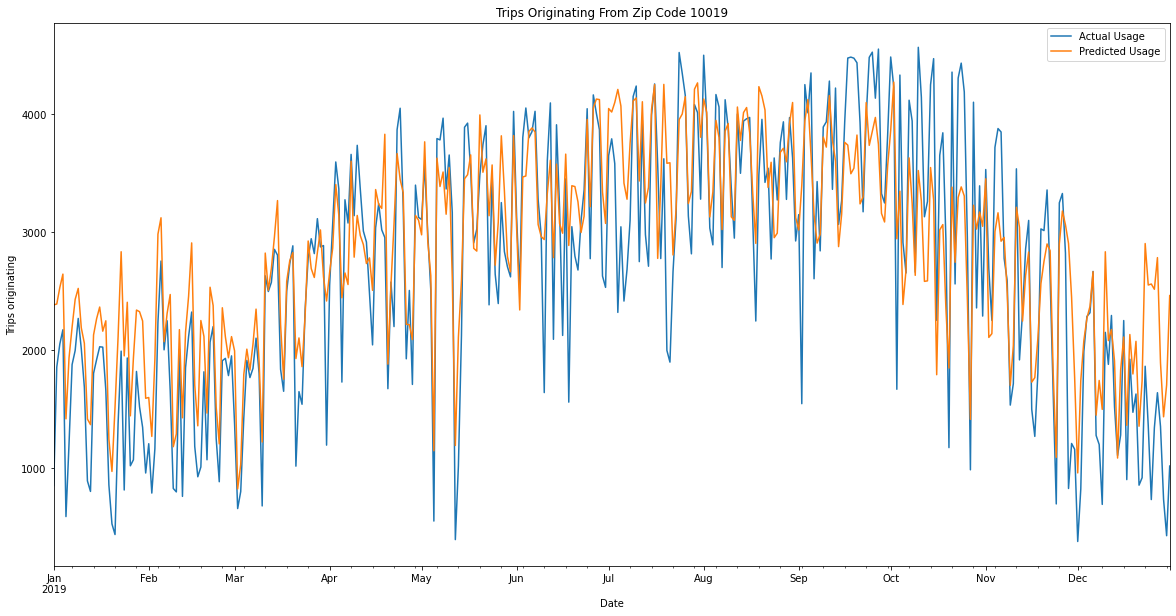

In [39]:
ax = plot1.plot.line(x='date', y = ['Actual Usage', 'Predicted Usage'], figsize=(20, 10))
ax.set_xlabel("Date")
ax.set_ylabel("Trips originating")
ax.set_title("Trips Originating From Zip Code 10019")


Let's formalize this accuracy metric using Mean Absolute Percentage Erorr (MAPE)

In [33]:
mape = sk.metrics.mean_absolute_percentage_error(sample_y['Actual Usage'], sample_pred['Predicted Usage'])
print("Our mean absolute percentage error for 10019 is", mape)

Our mean absolute percentage error for 10019 is 0.2600095889629522


Now let's sum all of the zip codes and see how accurate our aggregate prediction is.

In [34]:
#Now let's do the same thing, but for all stations in aggregate
predictionDF = predictionDF.drop(columns=['date'])
predictionDF['sum'] = predictionDF.sum(axis=1, numeric_only=True)
predictionDF.insert(loc=0, column='date', value=daterange2019)
predictionDF


,date,10043,00083,10001,10002,10003,10004,10005,10007,10009,...,11221,11222,11225,11231,11232,11233,11238,11249,11251,sum
0,2019-01-01,142.676767,1583.869380,2571.136719,2018.912930,3260.172204,464.706814,445.072807,781.396133,1814.949514,...,102.606627,787.722951,100.269986,654.068175,28.813965,31.444036,738.513168,730.079431,92.011255,49586.103208
1,2019-01-02,90.131504,841.395345,3005.309110,2005.078440,3553.965358,291.766822,447.872909,777.789539,1981.765153,...,86.550223,727.974903,74.846429,574.783074,17.203905,22.692285,667.162897,593.630535,68.528313,48675.662118
2,2019-01-03,103.279658,990.642109,3108.244358,2100.325093,3688.912223,335.207718,472.469108,826.397014,2046.978390,...,90.993905,773.866618,80.832359,612.677150,19.834224,24.735640,708.421996,643.703116,73.627283,51293.307157
3,2019-01-04,113.885786,1140.872547,3185.613546,2162.898589,3776.466864,367.929560,489.487856,860.209506,2072.695524,...,92.401376,803.396908,85.334414,641.278215,21.806964,26.050658,743.223010,679.032169,78.631222,53259.619445
4,2019-01-05,64.493627,1102.005377,1461.845937,1889.968845,2606.851338,232.542286,201.660862,484.502750,1662.877429,...,85.787288,699.172258,104.828678,549.052232,17.366841,25.318218,750.232565,675.221246,49.673173,35877.885815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,131.007555,1270.623681,3247.024291,2260.419763,3903.328445,427.617858,517.121071,920.265885,2156.551922,...,99.550233,856.658433,88.823212,680.372619,25.855971,28.456382,765.927255,738.650142,81.884448,55721.949827
361,2019-12-28,96.665446,1517.055944,1842.792049,2203.643886,3089.654228,351.194404,277.474247,635.820164,1890.515127,...,95.392347,824.697445,116.614522,661.023187,21.329588,26.830652,854.328623,812.445523,61.194494,44136.836486
362,2019-12-29,62.105253,1103.758368,1464.490661,1882.407430,2608.339796,229.572013,199.382754,483.689266,1651.883671,...,82.383568,685.109689,99.761210,544.279190,15.783289,22.671061,730.640256,664.535886,47.657645,35679.768826
363,2019-12-30,54.302441,346.469475,2325.966099,1490.803401,2735.105569,151.497649,333.024640,563.000576,1569.305317,...,69.059470,530.625039,50.493926,407.998560,14.515443,20.024285,480.563699,396.829157,52.000188,35741.981642


In [35]:
y_test_sum = y_test
y_test_sum['sum'] = y_test_sum.sum(axis=1, numeric_only=True)
y_test_sum


,date,10043,00083,10001,10002,10003,10004,10005,10007,10009,...,11221,11222,11225,11231,11232,11233,11238,11249,11251,sum
0,2019-01-01,45.0,1201.0,812.0,1072.0,1242.0,126.0,155.0,361.0,1013.0,...,54.0,350.0,74.0,340.0,5.0,11.0,493.0,305.0,36.0,21962.0
1,2019-01-02,60.0,1057.0,2273.0,1609.0,2539.0,296.0,376.0,639.0,1426.0,...,60.0,528.0,57.0,501.0,21.0,7.0,573.0,451.0,68.0,37797.0
2,2019-01-03,89.0,975.0,2577.0,1763.0,2781.0,310.0,415.0,641.0,1661.0,...,73.0,625.0,57.0,516.0,21.0,14.0,619.0,523.0,59.0,41676.0
3,2019-01-04,73.0,1091.0,2643.0,1942.0,2934.0,292.0,423.0,724.0,1853.0,...,73.0,652.0,66.0,574.0,18.0,21.0,703.0,568.0,59.0,43922.0
4,2019-01-05,5.0,294.0,702.0,1025.0,1384.0,50.0,105.0,191.0,941.0,...,49.0,332.0,54.0,293.0,2.0,20.0,462.0,301.0,21.0,17432.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,77.0,1024.0,1847.0,1632.0,2045.0,199.0,291.0,463.0,1494.0,...,133.0,451.0,57.0,299.0,10.0,34.0,466.0,346.0,44.0,31625.0
361,2019-12-28,70.0,1301.0,1270.0,1598.0,1940.0,166.0,159.0,337.0,1361.0,...,140.0,528.0,65.0,364.0,15.0,21.0,503.0,480.0,41.0,28306.0
362,2019-12-29,23.0,769.0,746.0,1053.0,1154.0,77.0,115.0,218.0,1036.0,...,120.0,354.0,43.0,198.0,6.0,12.0,332.0,267.0,23.0,17844.0
363,2019-12-30,14.0,168.0,750.0,650.0,902.0,72.0,103.0,172.0,699.0,...,41.0,207.0,24.0,136.0,1.0,10.0,182.0,141.0,16.0,12077.0


In [36]:
total_y = y_test_sum[['date', 'sum']]
total_y = total_y.rename(columns={'sum': 'Actual Usage'})
predictionDF = predictionDF[['date', 'sum']]
predictionDF = predictionDF.rename(columns={'sum': 'Predicted Usage'})

plot2 = total_y.merge(predictionDF)
plot2


,date,Actual Usage,Predicted Usage
0,2019-01-01,21962.0,49586.103208
1,2019-01-02,37797.0,48675.662118
2,2019-01-03,41676.0,51293.307157
3,2019-01-04,43922.0,53259.619445
4,2019-01-05,17432.0,35877.885815
...,...,...,...
360,2019-12-27,31625.0,55721.949827
361,2019-12-28,28306.0,44136.836486
362,2019-12-29,17844.0,35679.768826
363,2019-12-30,12077.0,35741.981642


Our final graph shows us the performance of our model. It does a reasonably good job of predicting usage. However, there is significant error in Jan-Feb and Sep-Oct. 

Text(0.5, 1.0, 'Trips Taken on Citi Bike, 2019')

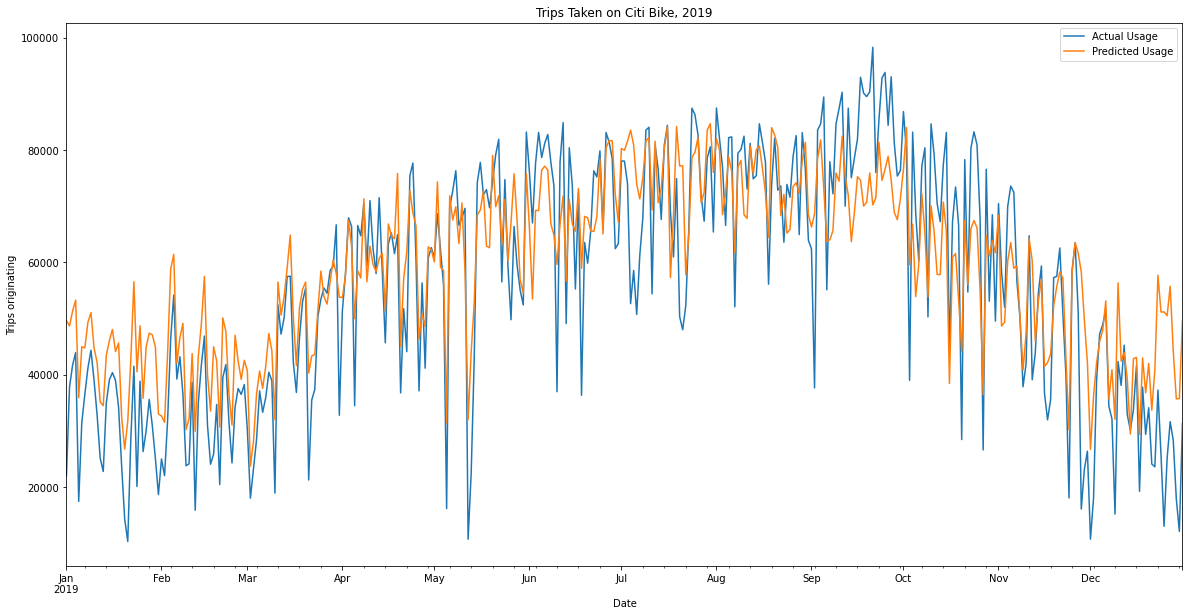

In [40]:
ax = plot2.plot.line(x='date', y = ['Actual Usage', 'Predicted Usage'], figsize=(20, 10))
ax.set_xlabel("Date")
ax.set_ylabel("Trips originating")
ax.set_title("Trips Taken on Citi Bike, 2019")


In [38]:
mape2 = sk.metrics.mean_absolute_percentage_error(plot2['Actual Usage'], plot2['Predicted Usage'])
print("Our mean absolute percentage error for the entire system is", mape2)

Our mean absolute percentage error for the entire system is 0.23321401967033778
